In [11]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import random
import matplotlib.pyplot as plt

In [12]:
def gen_station_names(amount):
    """
    Creates names for stations given an amount of stations.
    """
    name_list = ['Root']
    for name in range(amount):
        name_list.append(chr(65 + name))
    return name_list

names = gen_station_names(5)
names

['Root', 'A', 'B', 'C', 'D', 'E']

In [13]:
def gen_locations(name_list):
    """
    Given a list of station names, generates random locations.
    """
    location_list = []
    max_xy = math.ceil(len(name_list) / 2)

    while len(location_list) < len(name_list):

        new_location = [np.random.randint(0, max_xy), np.random.randint(0, max_xy)]
        if new_location not in location_list:
            location_list.append(new_location)
    return location_list

locations = gen_locations(names)
print(len(names), len(locations))
locations

6 6


[[2, 2], [2, 1], [0, 1], [0, 0], [1, 0], [1, 1]]

In [14]:
def gen_connections(name_list, location_list):
    """
    Takes a list of names and corresponding locations and generates connections between them.
    """
    connection_list = []
    final_list = []
    new_connection_list = []
    
    for station in range(len(name_list)):
        # Finds for a station which other stations can be directly connected to it
        possible_connections = [location for location in location_list if location_list[station][0] == location[0]
                                 or location_list[station][1] == location[1]]
        # Removes the station itself
        possible_connections.remove(location_list[station])

        # Remove too far stations
        fpc = []
        # Below on the y-axis
        if len([location for location in location_list if location[0] == location_list[station][0] and location[1] < location_list[station][1]]) > 0:
            fpc.append(max([location for location in location_list if location[0] == location_list[station][0] and location[1] < location_list[station][1]]))
        # Above on the y-axis
        if len([location for location in location_list if location[0] == location_list[station][0] and location[1] > location_list[station][1]]) > 0:
            fpc.append(min([location for location in location_list if location[0] == location_list[station][0] and location[1] > location_list[station][1]]))
        # Left on the x-axis
        if len([location for location in location_list if location[1] == location_list[station][1] and location[0] < location_list[station][0]]) > 0:
            fpc.append(max([location for location in location_list if location[1] == location_list[station][1] and location[0] < location_list[station][0]]))
        # Right on the x-axis
        if len([location for location in location_list if location[1] == location_list[station][1] and location[0] > location_list[station][0]]) > 0:
            fpc.append(min([location for location in location_list if location[1] == location_list[station][1] and location[0] > location_list[station][0]]))
        fpc
            
        # If no stations can be connected, create a station which is can subsequently be connected with another station
        if len(fpc) == 0:
            #print('Trown out {} because it could not be connected'.format(name_list[station]))
            name_list[station] = '-1'
            location_list[station] = [-1, -1]
            connection_list.append([-1, -1])
                
        else:
            # Pick a random amount of connections from the possible connections
            connection_list.append(random.sample(fpc, random.randint(1, len(fpc))))

    # Renames the locations to station names
    mapping_dict = dict(zip(map(tuple, location_list), name_list))

    #print('name_list: {}, location_list: {}, connection_list: {}'.format(name_list, location_list, connection_list))

    # Adds connections for newly generated stations to the list
    connection_list = connection_list + new_connection_list
    name_list = [x for x in name_list if x != '-1']
    location_list = [x for x in location_list if x != [-1, -1]]
    connection_list = [x for x in connection_list if x != [-1, -1]]
    # Change location
    for connection in connection_list:
        final_list.append([mapping_dict[tuple(item)] for item in connection])
    
    # Ensures bilateral connections between stations
    for station in range(len(name_list)):
        for connection in final_list[station]:
            # Adds for each station itself to the connection list of connected stations
            index = name_list.index(connection)
            temp_var = set(final_list[index])
            temp_var.add(name_list[station])
            final_list[index] = list(temp_var)
    
    return name_list, location_list, final_list
        


In [24]:
def gen_paths(df_stations, path_number, max_path_length):
    """
    Takes a list of stations and connections between the stations to create the desired amount of paths with the desired average length. 
    Note: Due to how the algorithm is set up this function can error when the root is non-exisiting in a test case, however this
        can never happen in evaluate_algorithm because they are trown out, therefore the root is always connected to something.
    """
    total_path_list = []

    # Generate n paths
    for n in range(path_number):

        local_path = ['Root']                       # Initialize the path
        length = random.randint(1, max_path_length) # Create a maximum random length for the path

        for step in range(length):
            # Finds for the current step the possible next steps
            choices = list(df_stations.iloc[df_stations.index[df_stations['Station_names'] == local_path[-1]]]['Connected_to'])[0]

            # Removes all stations which are already in the path
            choices = [station for station in choices if station not in local_path]

            # Stop if you can only go back
            if len(choices) == 0:
                break

            local_path.append(random.choice(choices))

        total_path_list.append(local_path)
    return total_path_list
            

In [16]:
def plot_graph(df_stations):
    G = nx.Graph()

    # Add nodes to the graph
    for i, row in df_stations.iterrows():
        G.add_node(row['Station_names'], pos=row['Station_locations'])

    # Add edges to the graph
    for i, row in df_stations.iterrows():
        for dest in row['Connected_to']:
            G.add_edge(row['Station_names'], dest)

    # Get positions of nodes
    pos = nx.get_node_attributes(G, 'pos')

    # Plot the graph
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_weight='bold')
    plt.title('Subway')
    return plt

In [17]:
amount_stations = 10
test_names = gen_station_names(amount_stations)
test_locations = gen_locations(test_names)
test_names, test_locations, test_connections = gen_connections(test_names, test_locations)

data = {
    'Station_names': test_names,
    'Station_locations': test_locations,
    'Connected_to': test_connections
}

df_stations = pd.DataFrame(data)


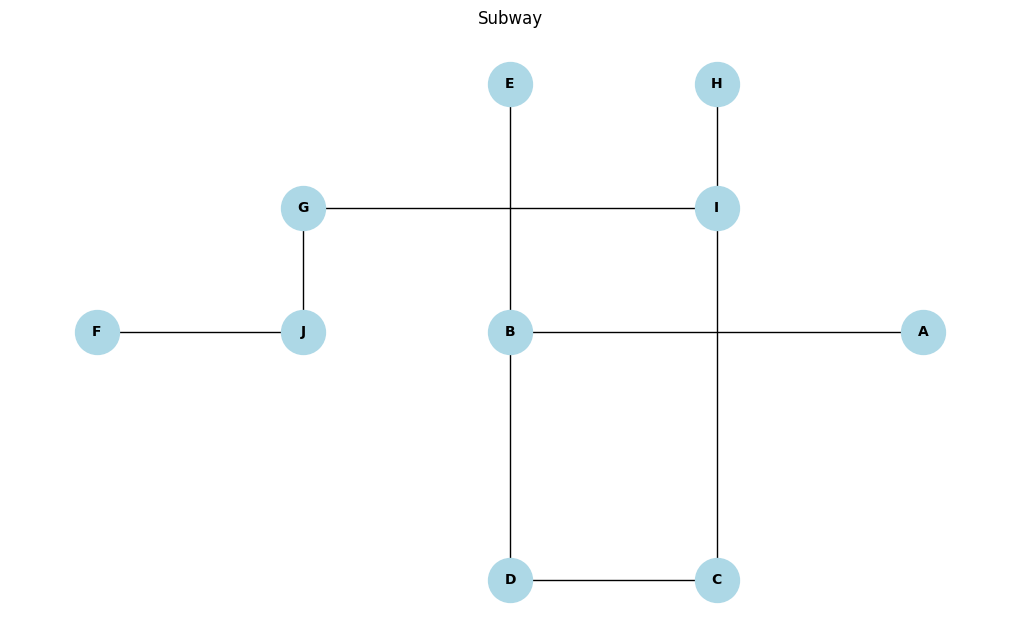

In [18]:
plot = plot_graph(df_stations)
plot.show()

In [19]:
def evaluate_algorithm(algorithm, amount_stations, test_size, path_number, max_path_length):
    """
    Tests a given algorithm with an amount of stations
    """

    trown_tests = 0
    for n in range(0, test_size):
        amount_stations = 10
        test_names = gen_station_names(amount_stations)
        test_locations = gen_locations(test_names)
        test_names, test_locations, test_connections = gen_connections(test_names, test_locations)

        # Trows out all the tests where the Root is disconnected
        if 'Root' not in test_names:
            trown_tests += 1

        else:
            data = {
                'Station_names': test_names,
                'Station_locations': test_locations,
                'Connected_to': test_connections
            }

            df_stations = pd.DataFrame(data)
            
            # Generate paths
            paths = gen_paths(df_stations, path_number, max_path_length)
            
            # TODO implement the algorithm test
    print(trown_tests)

In [25]:
# For 1 million test we trow out 17858 on 10 stations
evaluate_algorithm('placeholder', 10, 1000, 3, 10)


20
